# Additional Datasets
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate our structural preservation metrics on further datasets to confirm utility. Two datasets from the [UMAP _Nat. Biotech._ paper (Becht, _et al._ 2018)](https://www.nature.com/articles/nbt.4314) are evaluated to cover some key features of our framework:__  
* Larger datasets by number of cells
* CyTOF data in addition to scRNA-seq
* Previously annotated cell clusters for local and neighborhood structural preservation
* Confirmation of findings by Becht, _et al._ using our metrics to confirm utility and resolve claim of global vs. local structure preservation by UMAP compared to t-SNE

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [ ]:
# reload functions when editing file
del sys.modules['fcc_utils']
from fcc_utils import *

In [2]:
# ignore numba deprecation warnings given by sc.pp.neighbors()
import numba
import warnings
warnings.simplefilter('ignore', numba.errors.NumbaWarning)
warnings.simplefilter('ignore', numba.errors.NumbaDeprecationWarning)
warnings.simplefilter('ignore', numba.errors.NumbaPerformanceWarning)

---
### Samusik_01 Hematopoeitic CyTOF Dataset
[FlowRepository FR-FCM-ZZPH](https://flowrepository.org/id/FR-FCM-ZZPH)

In [13]:
sam = sc.read('../inputs/samusik_01.h5ad')

In [15]:
%%time
sam.raw = sam # save raw data before processing
arcsinh(sam, scale=1) # same transformation as Becht, et al.
sam.X = sam.layers['arcsinh_norm'].copy() # put arcsinh-transformed values in default slot

CPU times: user 26.5 ms, sys: 944 µs, total: 27.5 ms
Wall time: 26.4 ms


In [16]:
%time sc.tl.pca(sam, use_highly_variable=False, n_comps=2) # 2-component PCA for comparison to t-SNE and UMAP

CPU times: user 994 ms, sys: 260 ms, total: 1.25 s
Wall time: 131 ms


In [17]:
%%time
# create neighborhood graphs from PCA results and perform louvain clustering
sc.pp.neighbors(sam, n_neighbors=15, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)
sc.tl.louvain(sam, resolution=1.0, key_added='louvain', random_state=18, copy=False)
sam.obs['louvain_label'] = 'cluster_' + sam.obs['louvain'].astype(str)

CPU times: user 41.3 s, sys: 352 ms, total: 41.7 s
Wall time: 41.6 s


In [18]:
sam.write('../inputs/samusik_01_.h5ad', compression='gzip')

... storing 'louvain_label' as categorical


In [ ]:
sam = sc.read('../inputs/samusik_01_.h5ad')

../fcc_utils.py:146: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if IDs == 'all':


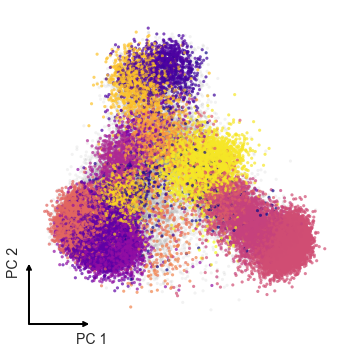

In [19]:
DR_plot(dim_name='PC').plot_IDs(sam, use_rep='X_pca', obs_col='label', IDs=np.arange(1,25), pt_size=10, save_to='outputs/samusik_PCA_label.png')

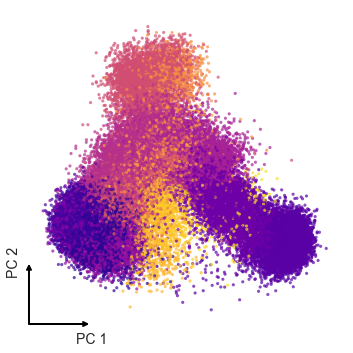

In [20]:
DR_plot(dim_name='PC').plot_IDs(sam, use_rep='X_pca', obs_col='louvain_label', pt_size=10, save_to='outputs/samusik_PCA_clu.png')

In [21]:
%time sc.tl.umap(sam, random_state=18, min_dist=0.02)

CPU times: user 1min 21s, sys: 1.33 s, total: 1min 22s
Wall time: 54.3 s


../fcc_utils.py:146: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if IDs == 'all':


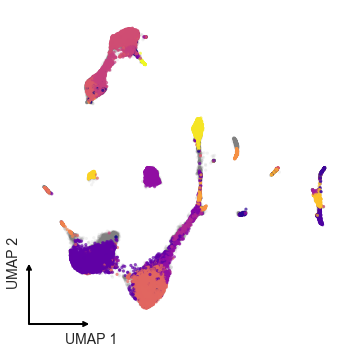

In [22]:
DR_plot(dim_name='UMAP').plot_IDs(sam, use_rep='X_umap', obs_col='label', IDs=np.arange(1,25), pt_size=10, save_to='outputs/samusik_UMAP_label.png')

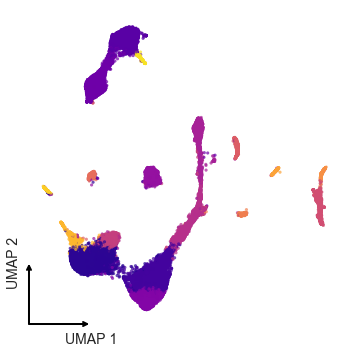

In [23]:
DR_plot(dim_name='UMAP').plot_IDs(sam, use_rep='X_umap', obs_col='louvain_label', pt_size=10, save_to='outputs/samusik_UMAP_clu.png')

In [24]:
%time sc.tl.tsne(sam, random_state=18, use_rep='X', perplexity=30, n_jobs=4)

CPU times: user 12min 7s, sys: 14.2 s, total: 12min 21s
Wall time: 12min 22s


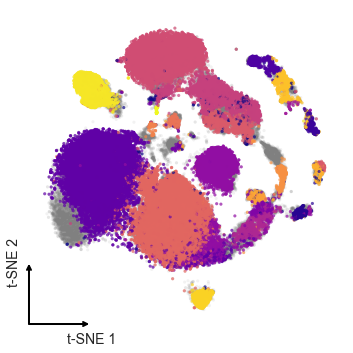

In [25]:
DR_plot(dim_name='t-SNE').plot_IDs(sam, use_rep='X_tsne', obs_col='label', IDs=np.arange(1,25), pt_size=10, save_to='outputs/samusik_tSNE_label.png')

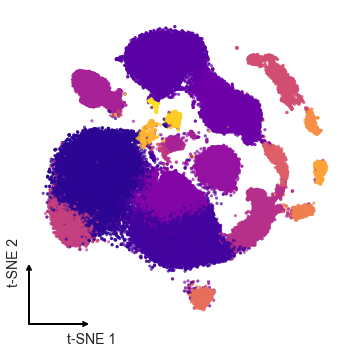

In [26]:
DR_plot(dim_name='t-SNE').plot_IDs(sam, use_rep='X_tsne', obs_col='louvain_label', pt_size=10, save_to='outputs/samusik_tSNE_clu.png')

---
### Structural Preservation

In [30]:
sam.obs = pd.DataFrame(sam.obs.values.byteswap().newbyteorder(), columns=sam.obs.columns)

AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 


In [31]:
idx = np.random.choice(np.arange(sam.n_obs), 10000, replace=False)

In [32]:
sam_10k = sam[idx].copy()
sam_10k

Transforming to str index.


AnnData object with n_obs × n_vars = 10000 × 39 
    obs: 'Time', 'Cell_length', 'BC1', 'BC2', 'BC3', 'BC4', 'BC5', 'BC6', 'DNA1', 'DNA2', 'Cisplatin', 'beadDist', 'sample', 'event', 'label', 'name', 'louvain', 'louvain_label'
    uns: 'pca', 'neighbors', 'louvain'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    layers: 'arcsinh_norm'

**PCA**

In [33]:
%time pca_corr, pca_EMD, pca_knnP = structure_preservation_sc(sam_10k, latent='X_pca', native='X', k=300)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(pca_corr[0],4), round(pca_EMD,4), round(pca_knnP,4)))

Calculating unique distances for native space, X
Calculating unique distances for latent space, X_pca
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
300-nearest neighbor calculation for native space, X
300-nearest neighbor calculation for latent space, X_pca
Determining nearest neighbor preservation
Done!
CPU times: user 1min, sys: 2.12 s, total: 1min 2s
Wall time: 1min 2s
R: 0.8681
EMD: 0.1433
Knn %: 94.732


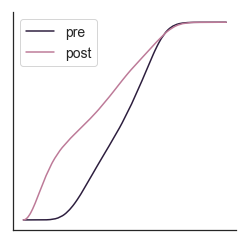

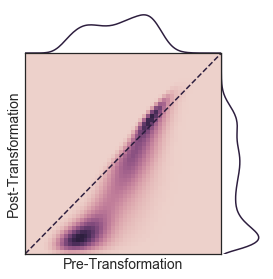

In [34]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(sam_10k.uns['X_norm_distances'], sam_10k.uns['X_pca_norm_distances'])
joint_plot_distance_correlation(sam_10k.uns['X_norm_distances'], sam_10k.uns['X_pca_norm_distances'])

**t-SNE**

In [35]:
%time tsne_corr, tsne_EMD, tsne_knnP = structure_preservation_sc(sam_10k, latent='X_tsne', native='X', k=300)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(tsne_corr[0],4), round(tsne_EMD,4), round(tsne_knnP,4)))

Calculating unique distances for latent space, X_tsne
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
300-nearest neighbor calculation for latent space, X_tsne
Determining nearest neighbor preservation
Done!
CPU times: user 43.5 s, sys: 1.46 s, total: 45 s
Wall time: 44.3 s
R: 0.5778
EMD: 0.0833
Knn %: 95.4013


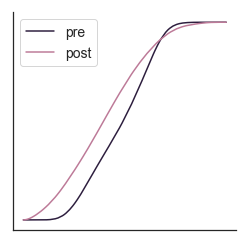

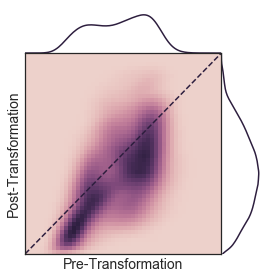

In [36]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(sam_10k.uns['X_norm_distances'], sam_10k.uns['X_tsne_norm_distances'])
joint_plot_distance_correlation(sam_10k.uns['X_norm_distances'], sam_10k.uns['X_tsne_norm_distances'])

**UMAP**

In [37]:
%time umap_corr, umap_EMD, umap_knnP = structure_preservation_sc(sam_10k, latent='X_umap', native='X', k=300)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(umap_corr[0],4), round(umap_EMD,4), round(umap_knnP,4)))

Calculating unique distances for latent space, X_umap
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
300-nearest neighbor calculation for latent space, X_umap
Determining nearest neighbor preservation
Done!
CPU times: user 43.6 s, sys: 1.47 s, total: 45.1 s
Wall time: 44.4 s
R: 0.7953
EMD: 0.1042
Knn %: 95.4049


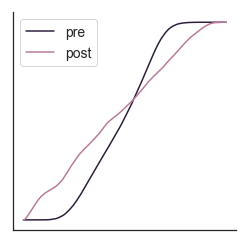

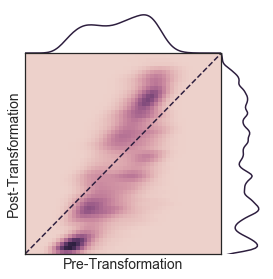

In [38]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(sam_10k.uns['X_norm_distances'], sam_10k.uns['X_umap_norm_distances'])
joint_plot_distance_correlation(sam_10k.uns['X_norm_distances'], sam_10k.uns['X_umap_norm_distances'])